In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import statsmodels.api as sm
from sklearn import metrics
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
import plotly.plotly as py
init_notebook_mode(connected=True)

In [3]:
df = pd.read_csv("data_hackathon_v04.csv", sep='|')

In [4]:
len(df)

1117300

In [5]:
df.head()

ride_id                     created_at  \
0  000002b3a3014388a6c62fdda1d03de1n  2018-12-14 23:00:00.043000000   
1  000013de085e4be4a2cd27d9112f7bdbn  2018-10-13 23:59:00.580000000   
2  000040911549444d8ad461c69370e883n  2018-08-25 21:40:52.537000000   
3  0000759fc38a410e8d8802610800ccacn  2018-12-08 13:43:41.357000000   
4  0000e61e5282484d943291df7266ee33n  2019-01-18 09:18:44.377000000   

   pickup_lat  pickup_lng  dropoff_lat  dropoff_lng  \
0   49.824671   24.013246    49.784729    24.060303   
1   49.837906   24.029772    49.841217    23.974363   
2   49.839718   23.994425    49.840610    24.029135   
3   49.829708   24.044172    49.869137    24.010246   
4   49.837013   24.034357    49.832710    23.999216   

                                             user_id  \
0  3900450045004500300042003700310037003800460031...   
1  6227785C7862375C7863623F5C7866652E285F2D5C7861...   
2  62277C6C5C7866386C572C795C7838315C7831645C7863...   
3  62275C7864335C78393135635C6E5C7830355C7839645C...   
4  3300360037004600420041003600300032003500410033...   

                          driver_id  ride_distance  canceled_by_client  \
0  a429c637c1244bb7a1d606d2b9987bdd           7.97                   0   
1                               NaN           5.62                   1   
2  7323767ede0349d1a7bfe743a091d63c           3.17                   0   
3                               NaN           5.87                   1   
4  2913413c2bf748d7932d1d587c8aef13           3.39                   0   

   canceled_by_driver  ride_to_suburb  
0                   0               0  
1                   0               0  
2                   0               0  
3                   0               0  
4                   0               0

In [6]:
df['created_at'] = pd.to_datetime(df['created_at'])
df = df[np.abs(df.pickup_lat-df.pickup_lat.mean()) <= (3*df.pickup_lat.std())]
df = df[np.abs(df.pickup_lng-df.pickup_lng.mean()) <= (3*df.pickup_lng.std())]
df = df[np.abs(df.dropoff_lat-df.dropoff_lat.mean()) <= (3*df.dropoff_lat.std())]
df = df[np.abs(df.dropoff_lng-df.dropoff_lng.mean()) <= (3*df.dropoff_lng.std())]

In [7]:
len(df)

1089705

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f18ff98>,
      dtype=object)

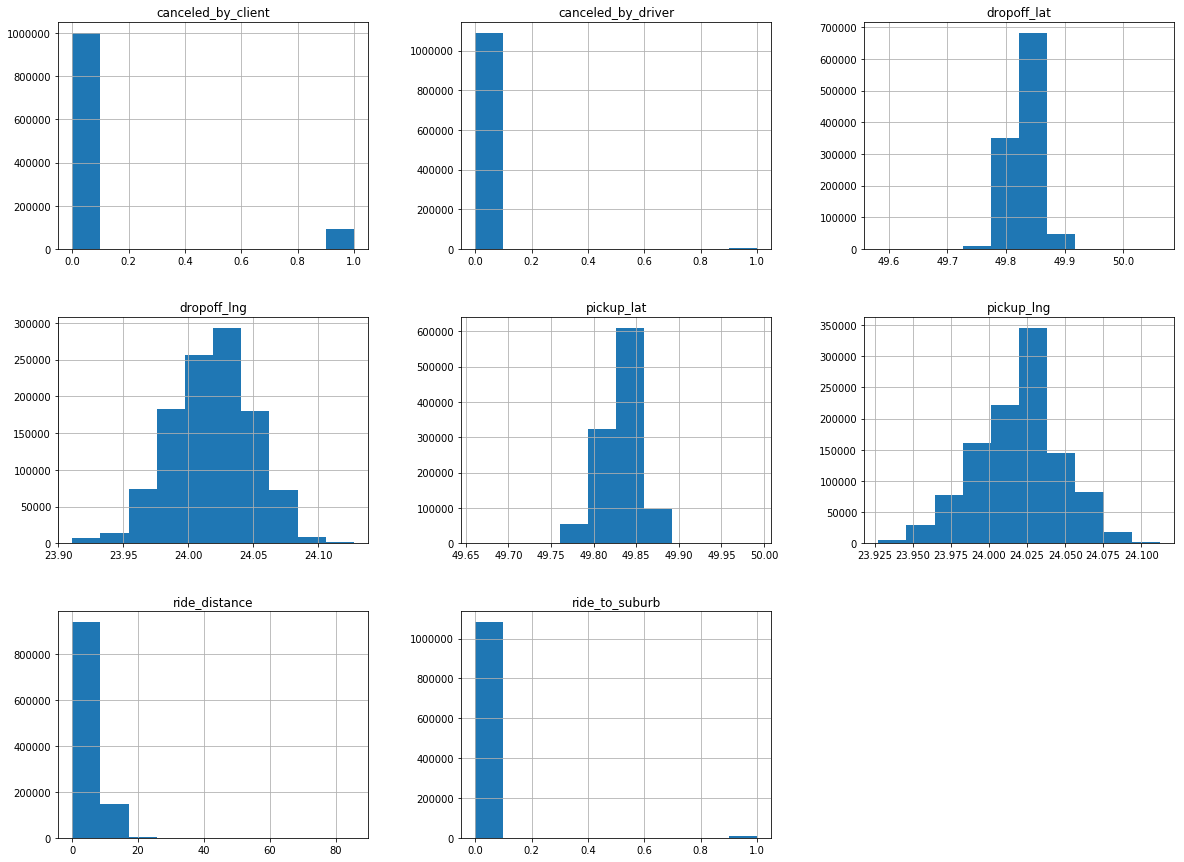

In [8]:
fig = plt.figure(figsize = (20,15))
ax = fig.gca()
df.hist(ax = ax)

In [9]:
%%time
df['time'] = df['created_at'].apply(lambda x: pd.Timestamp.round(x,'h'))

CPU times: user 3min 32s, sys: 10 s, total: 3min 42s
Wall time: 3min 44s


In [10]:
dataset_full = pd.DataFrame(df['ride_id'].groupby(df.time).count())

In [11]:
len(dataset_full)

4433

In [12]:
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

def plotly_df(df, title = '', plot_in=True):
    data = []
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
        
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    #iplot(fig, show_link=False)
    if plot_in:
        configure_plotly_browser_state()
        iplot(fig, show_link=False)
    else:    
        py.iplot(fig)
plotly_df(dataset_full, title = "Demand distribution", plot_in=True)

In [29]:
def model(df, n_pred=7*24, seasonality=7*24, plots=False, type_='forward'):
    if type_ == 'forward':
        dataset = df.copy()
    elif type_ == 'backward':
        split_point = len(df) - n_pred
        dataset, validation = df[0:split_point], df[split_point:]
    
    def difference(dataset, interval=1):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        return np.array(diff)
    def inverse_difference(history, yhat, interval=1):
        return yhat + history[-interval]
    
    X = dataset['count'].values
    differenced = difference(X, seasonality)
    
    differenced = np.array(differenced, dtype=float)
    
    # fit model
    model = ARIMA(differenced, order=(4,1,2))
    model_fit = model.fit(disp=0)
#     print(model_fit.summary())
    
    forecast = model_fit.forecast(steps=n_pred)
    f_plot = forecast[1]
    forecast = forecast[0]

    history = [x for x in X]
    day = 1
    forecast_temp = []
    for yhat in forecast:
        inverted = inverse_difference(history, yhat, seasonality)
        forecast_temp.append(inverted)
        history.append(inverted)
        day += 1
        
    forecast_temp = list(map(round,forecast_temp))

    if plots == True:
        #plot original dataset
        plotly_df(df, title = "Demand distribution within one district", plot_in=True)
        #plot differenced dataset
        diff_plot = df.copy()[:len(differenced)]
        diff_plot.ride_id = differenced
        plotly_df(diff_plot, title = "Differenced demand distribution", plot_in=True)
        #plot correlograms
        fig = plt.figure(figsize=(18,8))
        ax1 = fig.add_subplot(211)
        fig = sm.graphics.tsa.plot_acf(differenced, lags=25, ax=ax1)
        ax2 = fig.add_subplot(212)
        fig = sm.graphics.tsa.plot_pacf(differenced, lags=25, ax=ax2)   
    
        if type_ == 'forward':
            plt.figure(figsize=(15,8))
            plt.plot(np.arange(len(dataset)), dataset)
            plt.plot(np.arange(len(dataset)+1,len(dataset)+len(forecast_temp)+1), forecast_temp, color='yellow')
            plt.show()
        
        elif type_ == 'backward':
        #plot result
        #     plt.figure(figsize=(15,8))
        #     plt.plot(np.arange(0,len(df)), df, color='blue')
        #     plt.plot(np.arange(len(dataset)+1,len(dataset)+len(forecast_temp)+1), forecast_temp, color='yellow')
        #     plt.show()
        
        #plot zoomed result
            plt.figure(figsize=(15,8))
            plt.plot(np.arange(len(df)-n_pred*2,len(df)), df[-n_pred*2:])
            plt.plot(np.arange(len(dataset)+1,len(dataset)+len(forecast_temp)+1), forecast_temp, color='yellow')
            plt.show()
            
    if type_ == 'forward':   
        return forecast_temp
    elif type_ == 'backward':
        abse = metrics.mean_absolute_error(validation,forecast_temp)
        mse = metrics.mean_squared_error(validation,forecast_temp)
        r2_score = metrics.r2_score(validation,forecast_temp)
        return forecast_temp, abse, mse, r2_score

In [55]:
def model(df, n_pred=7*24, seasonality=7*24, plots=False, type_='forward'):
    if type_ == 'forward':
        dataset = df.copy()
    elif type_ == 'backward':
        split_point = len(df) - n_pred
        dataset, validation = df[0:split_point], df[split_point:]
    
    def difference(dataset, interval=1):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        return np.array(diff)
    def inverse_difference(history, yhat, interval=1):
        return yhat + history[-interval]
    
    X = dataset['count'].values
    differenced = difference(X, seasonality)
    
    differenced = np.array(differenced, dtype=float)
    
    # fit model
    model = ARIMA(differenced, order=(4,1,2))
    model_fit = model.fit(disp=0)
#     print(model_fit.summary())
    
    forecast = model_fit.forecast(steps=n_pred)
    f_plot = forecast[1]
    forecast = forecast[0]

    history = [x for x in X]
    day = 1
    forecast_temp = []
    for yhat in forecast:
        inverted = inverse_difference(history, yhat, seasonality)
        forecast_temp.append(inverted)
        history.append(inverted)
        day += 1
        
    forecast_temp = list(map(round,forecast_temp))

    if plots == True:
#         #plot original dataset
#         plotly_df(df, title = "Demand distribution within one district", plot_in=True)
#         #plot differenced dataset
#         diff_plot = df.copy()[:len(differenced)]
#         diff_plot.ride_id = differenced
#         plotly_df(diff_plot, title = "Differenced demand distribution", plot_in=True)
        #plot correlograms
#         fig = plt.figure(figsize=(18,8))
#         ax1 = fig.add_subplot(211)
#         fig = sm.graphics.tsa.plot_acf(differenced, lags=25, ax=ax1)
#         ax2 = fig.add_subplot(212)
#         fig = sm.graphics.tsa.plot_pacf(differenced, lags=25, ax=ax2)   
    
        if type_ == 'forward':
            plt.figure(figsize=(15,8))
            plt.plot(np.arange(len(dataset)), dataset)
            plt.plot(np.arange(len(dataset)+1,len(dataset)+len(forecast_temp)+1), forecast_temp, color='yellow')
            plt.show()
        
        elif type_ == 'backward':
        #plot result
        #     plt.figure(figsize=(15,8))
        #     plt.plot(np.arange(0,len(df)), df, color='blue')
        #     plt.plot(np.arange(len(dataset)+1,len(dataset)+len(forecast_temp)+1), forecast_temp, color='yellow')
        #     plt.show()
        
        #plot zoomed result
            plt.figure(figsize=(15,8))
            plt.plot(np.arange(len(df)-n_pred*2,len(df)), df[-n_pred*2:])
            plt.plot(np.arange(len(dataset)+1,len(dataset)+len(forecast_temp)+1), forecast_temp, color='yellow')
            plt.show()
            
    if type_ == 'forward':   
        return forecast_temp
    elif type_ == 'backward':
        abse = metrics.mean_absolute_error(validation,forecast_temp)
        mse = metrics.mean_squared_error(validation,forecast_temp)
        r2_score = metrics.r2_score(validation,forecast_temp)
        return forecast_temp, abse, mse, r2_score

In [15]:
lbl_df = pd.read_csv("labeled_data.csv", sep=',')

In [16]:
lbl_df['created_at'] = pd.to_datetime(lbl_df['created_at'])
lbl_df['month'] = lbl_df['created_at'].dt.month
lbl_df['month_day'] = lbl_df['created_at'].dt.day
lbl_df['week_day'] = lbl_df['created_at'].dt.weekday
lbl_df['hour'] = lbl_df['created_at'].dt.hour
lbl_df['time'] = lbl_df['created_at'].apply(lambda x: pd.Timestamp.round(x,'h'))

In [17]:
district_list = lbl_df.pickup_district.unique()

In [58]:
def start(type_):
    if type_=='forward':
        skipped_f = []
        bad_f = []
        forecast_future = {}
    elif type_=='backward':
        skipped = []
        bad = []
        district_metrics = {}
        forecast = {}
    for district in district_list:
        print('District code: ', district)
        df_d = lbl_df[lbl_df.pickup_district == district]
        if len(df_d) < 200:
            print("Skipped, lack of data")
            if type_=='forward':
                skipped_f.append(district)
            elif type_=='backward':
                skipped.append(district)
            continue
        ldf_d = pd.DataFrame(df_d['ride_id'].groupby(df_d.time).count())
        df1 = pd.DataFrame(index = pd.date_range(start='2018-08-21 00:00:00', end='2019-02-21 16:00:00', freq='H'))
        s=[]
        t = ldf_d.index.tolist()
        right = df1.index.tolist()
        for time in right:
            if time in t:
                s.append(ldf_d.loc[time].ride_id)
            else:
                s.append(0)
        df1['count'] = s
        try:
            if type_=='forward':
                forecast_temp = model(df1, plots=True, type_=type_)
            elif type_=='backward':
                forecast_temp, abse, mse, r2_score = model(df1, plots=True, type_=type_)
        except Exception:
            print("\nModel is not applicable")
            if type_=='forward':
                bad_f.append(district)
            elif type_=='backward':
                bad.append(district)
            continue
        if type_=='forward':  
            forecast_future[district] = forecast_temp
        elif type_=='backward':
            print("Mean absolute error: ", abse)
            print("Mean squared error: ", mse)
            print("R2 score: ", r2_score)
            district_metrics[district] = [abse, mse, r2_score]
            forecast[district] = forecast_temp
    if type_=='forward': return forecast_future
    elif type_=='backward': return forecast, district_metrics

District code:  871e7689cffffff


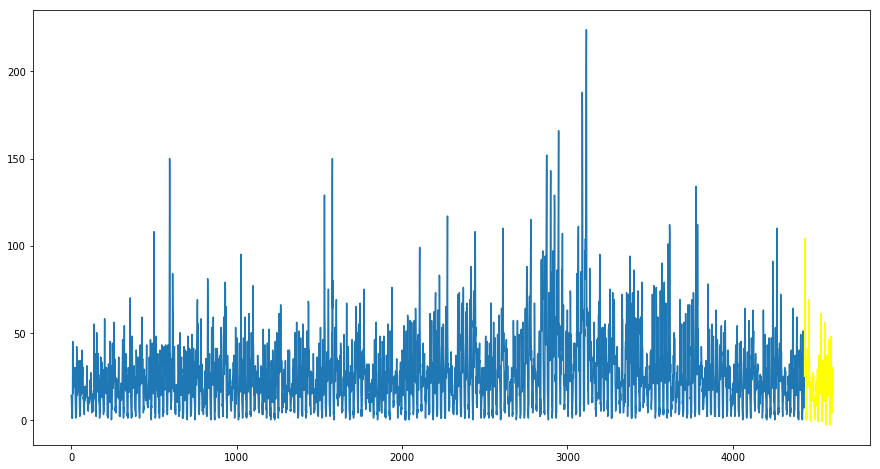

District code:  871e76883ffffff


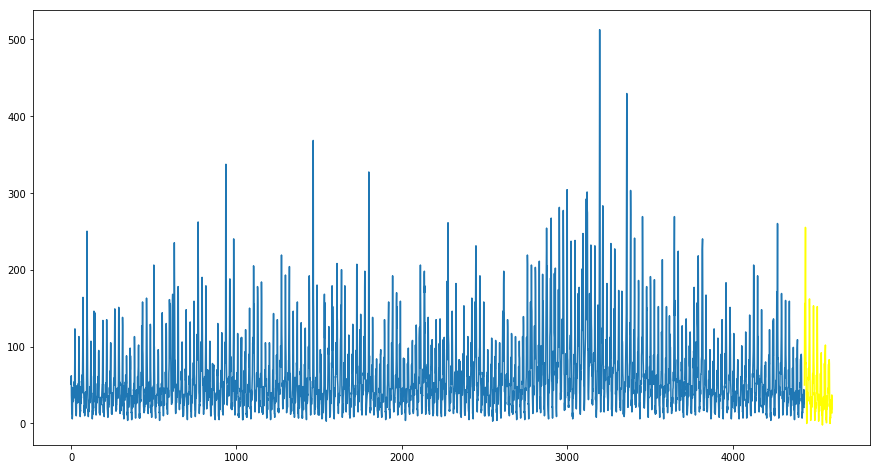

District code:  871e76882ffffff


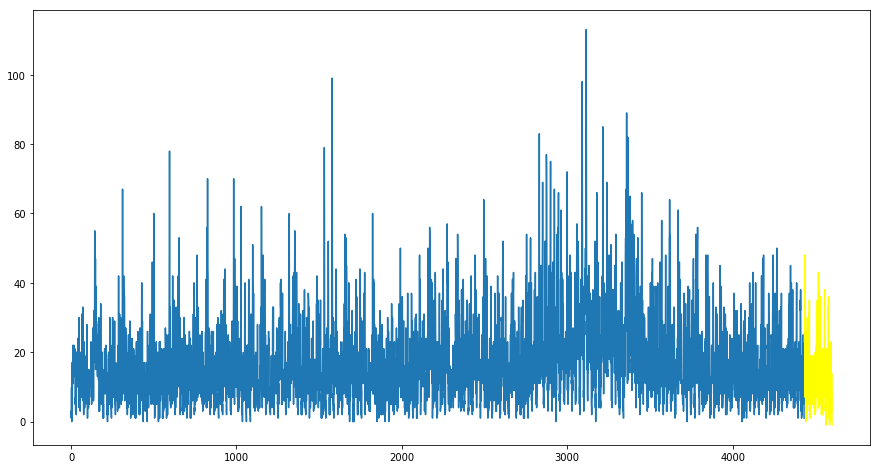

District code:  871e7689dffffff


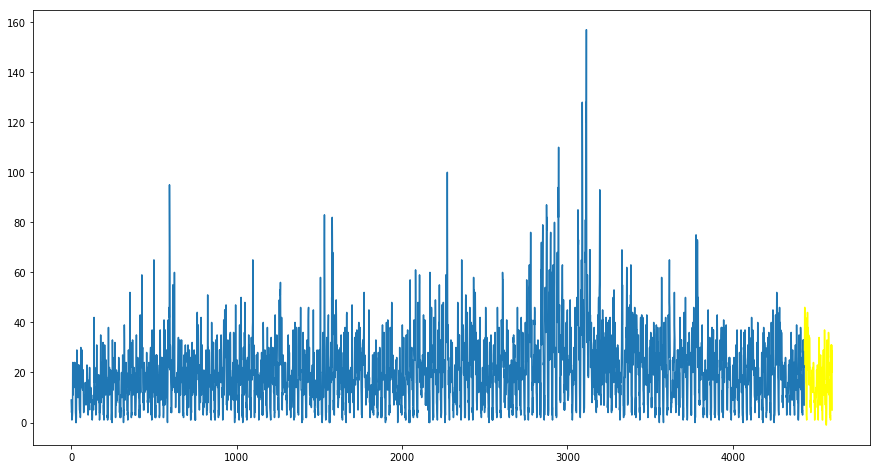

District code:  871e768b1ffffff


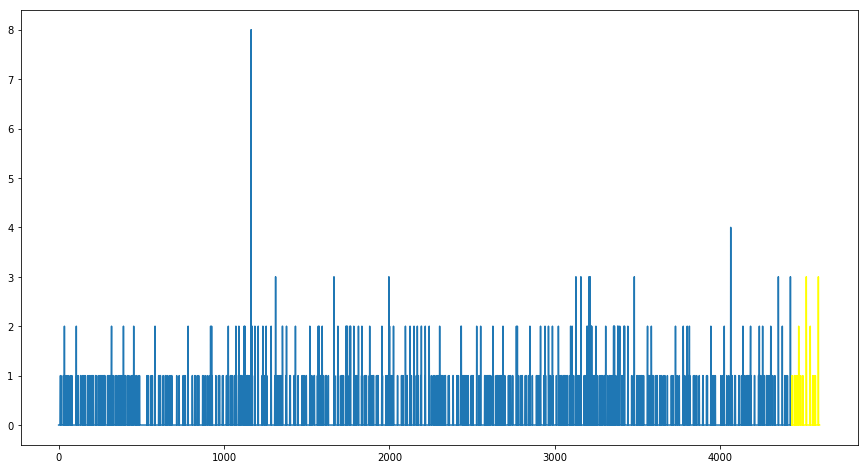

District code:  871e76135ffffff


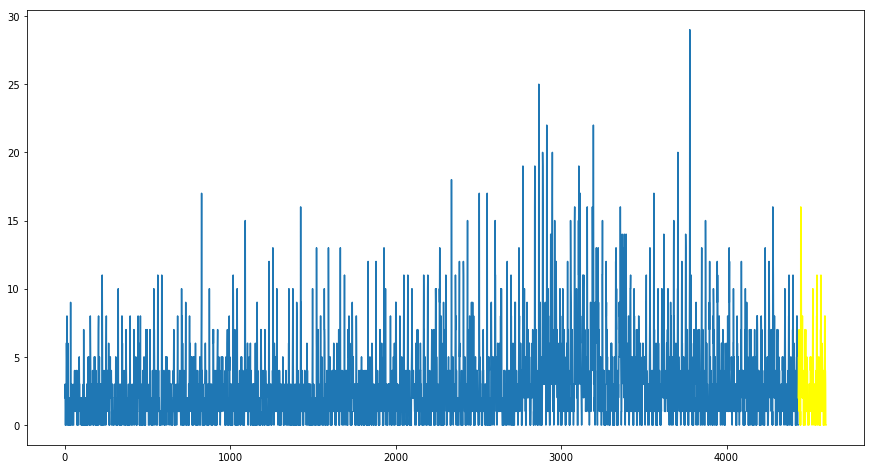

District code:  871e76899ffffff


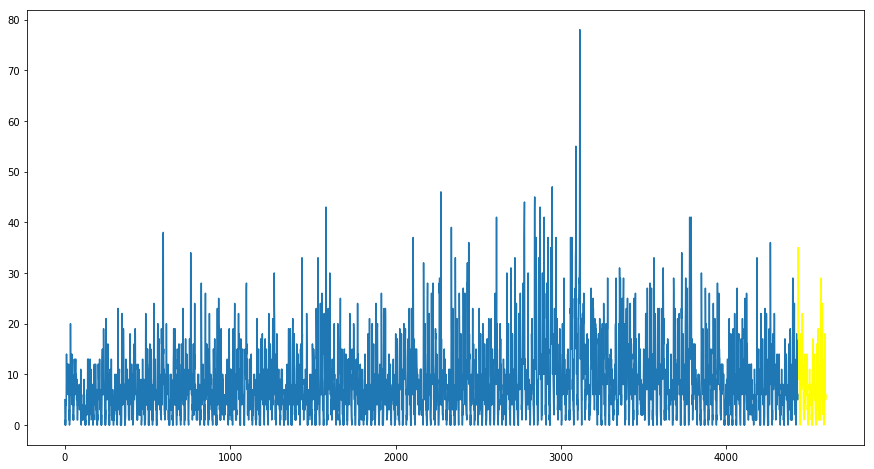

District code:  871e76895ffffff


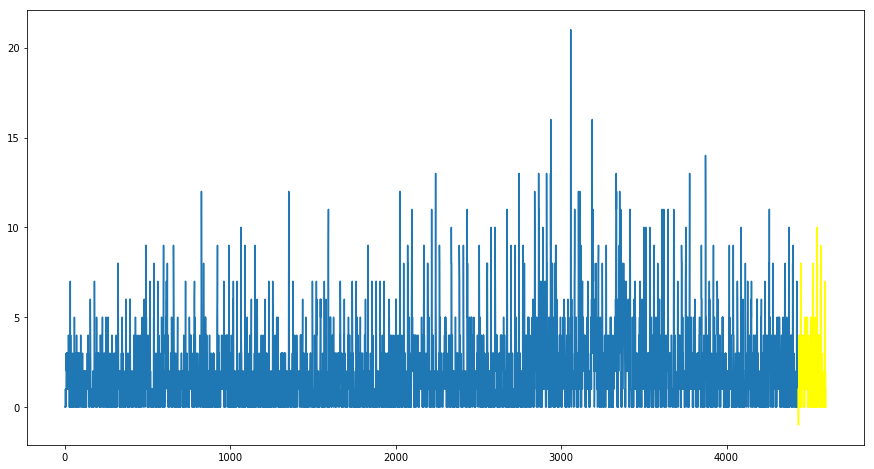

District code:  871e76898ffffff


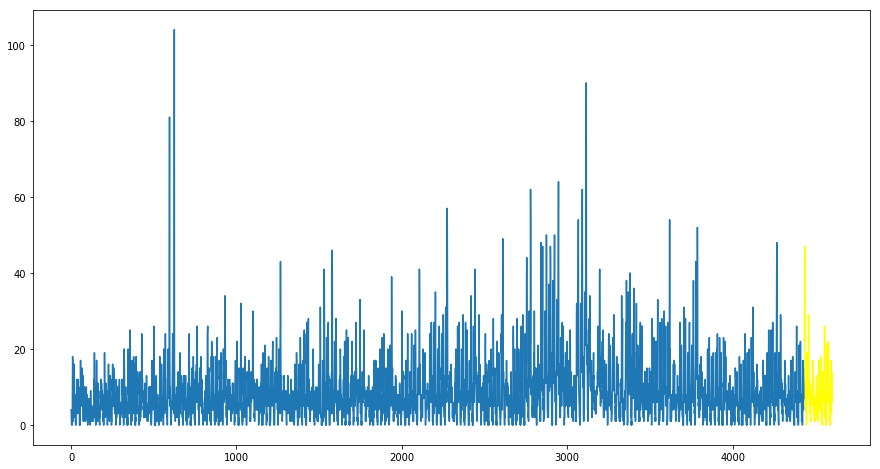

District code:  871e76126ffffff


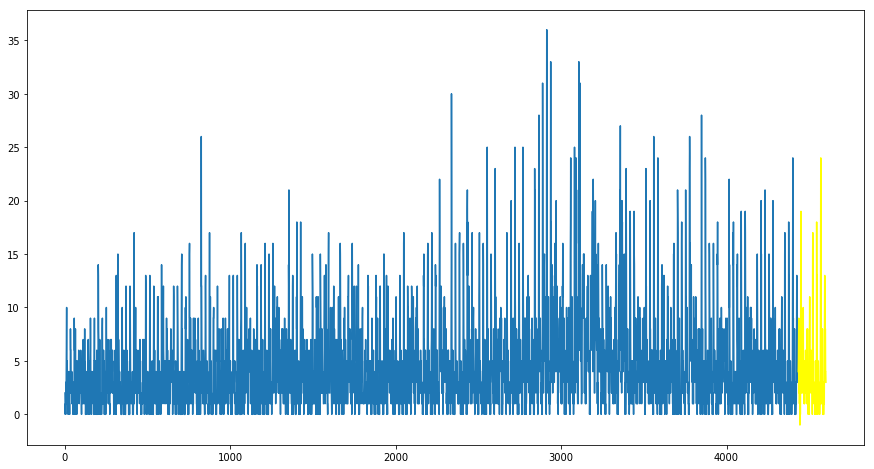

District code:  871e76880ffffff


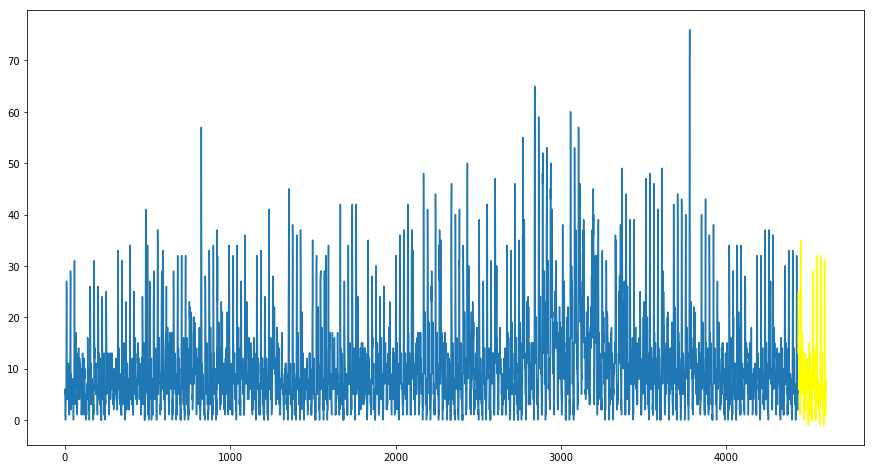

District code:  871e76881ffffff


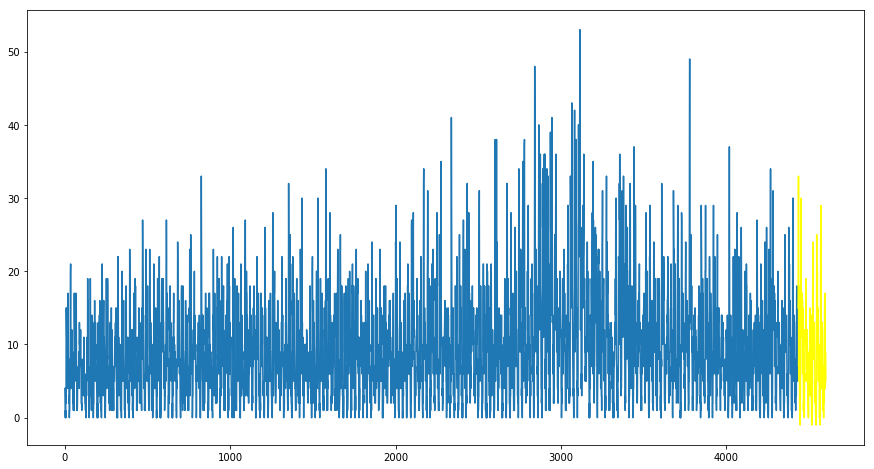

District code:  871e76885ffffff


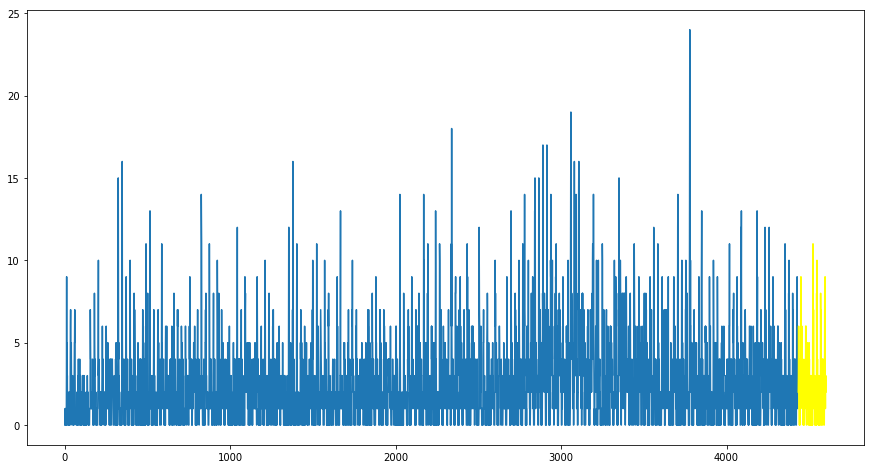

District code:  871e7689affffff


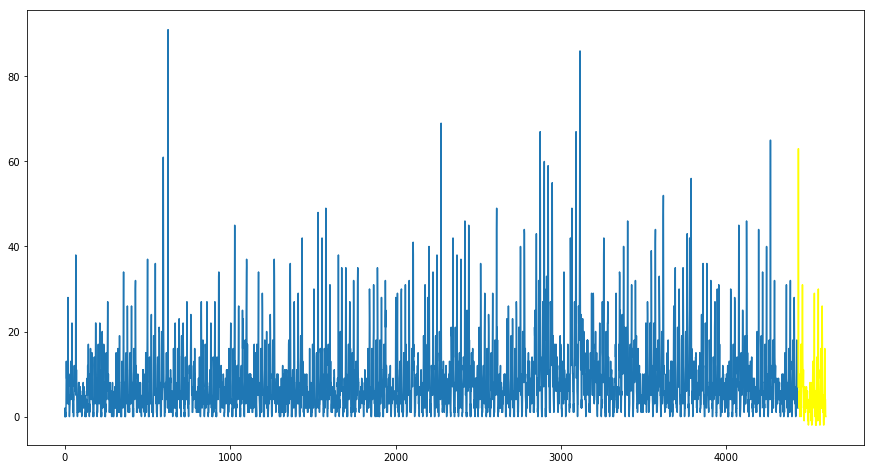

District code:  871e7688affffff


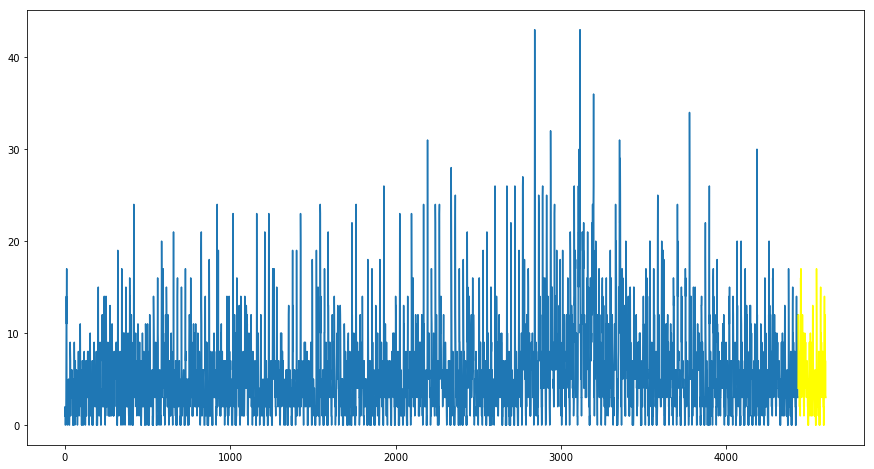

District code:  871e76134ffffff


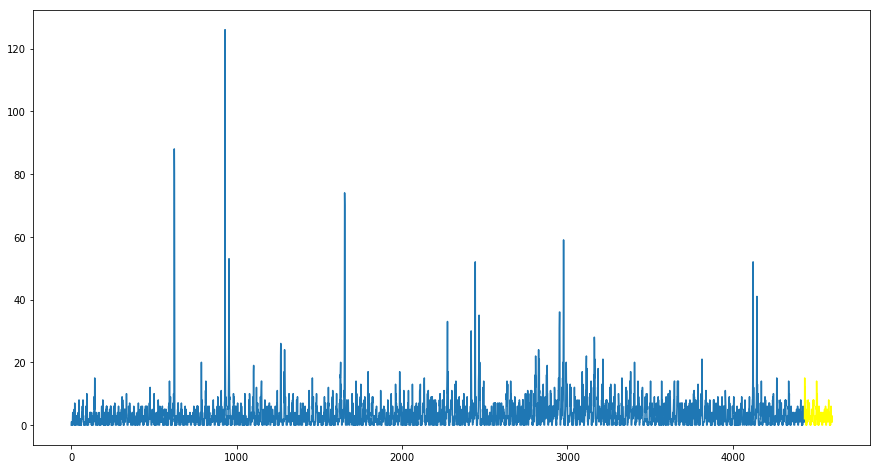

District code:  871e76c6dffffff


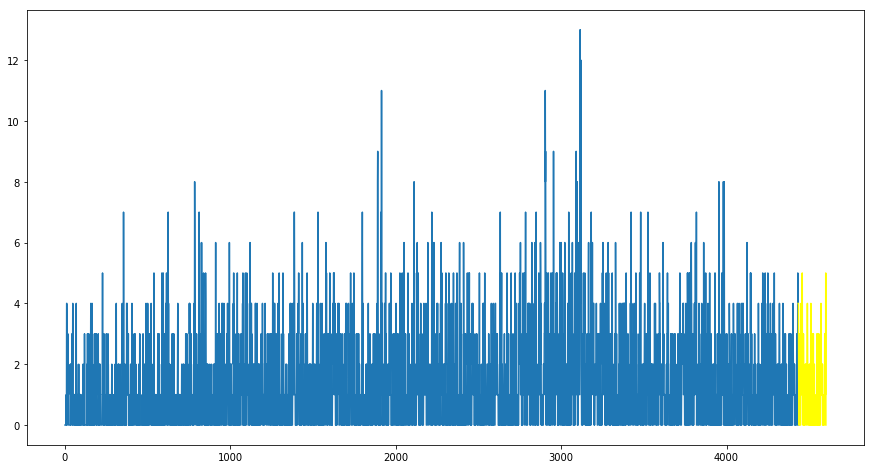

District code:  871e76891ffffff


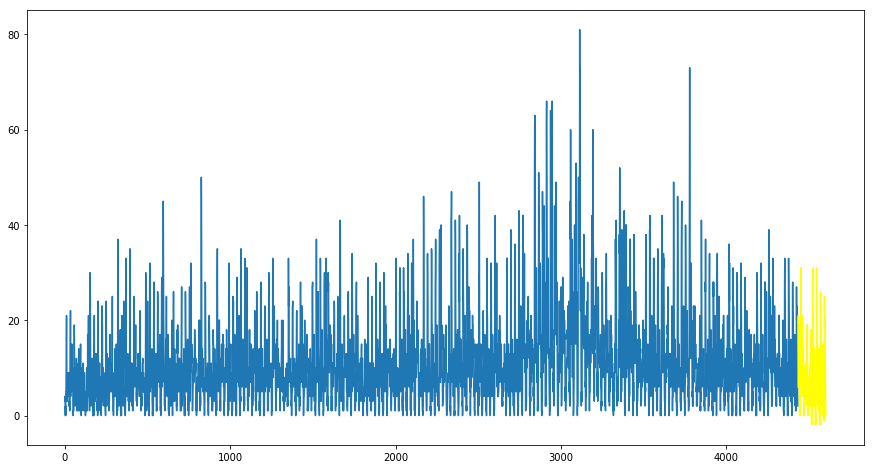

District code:  871e7689effffff


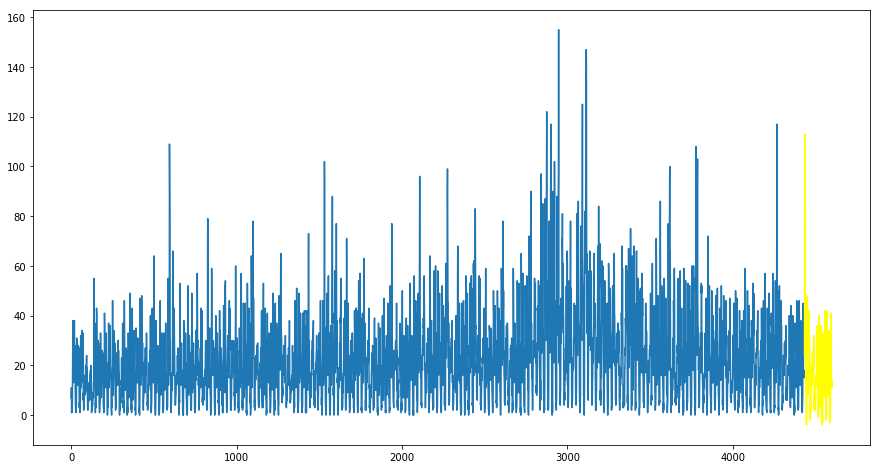

District code:  871e76893ffffff


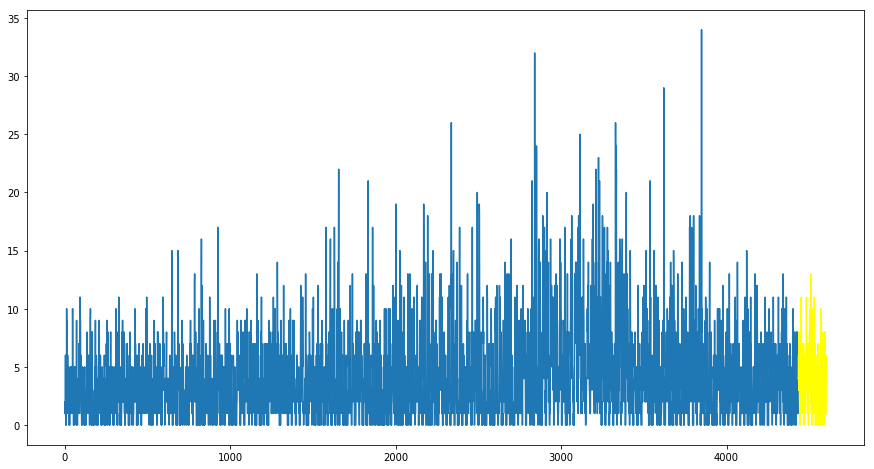

District code:  871e7689bffffff


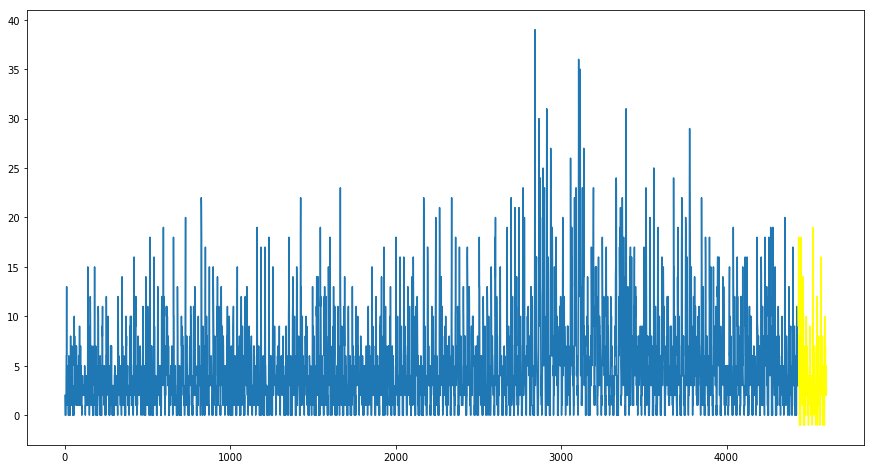

District code:  871e7688effffff


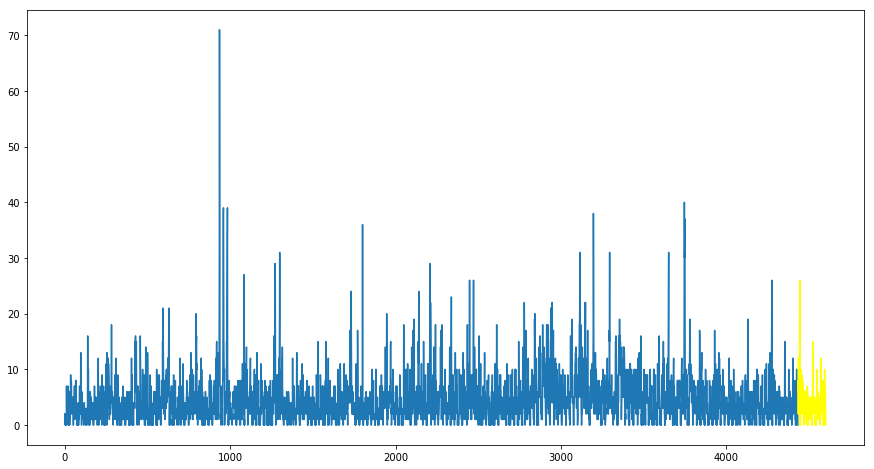

District code:  871e768b3ffffff


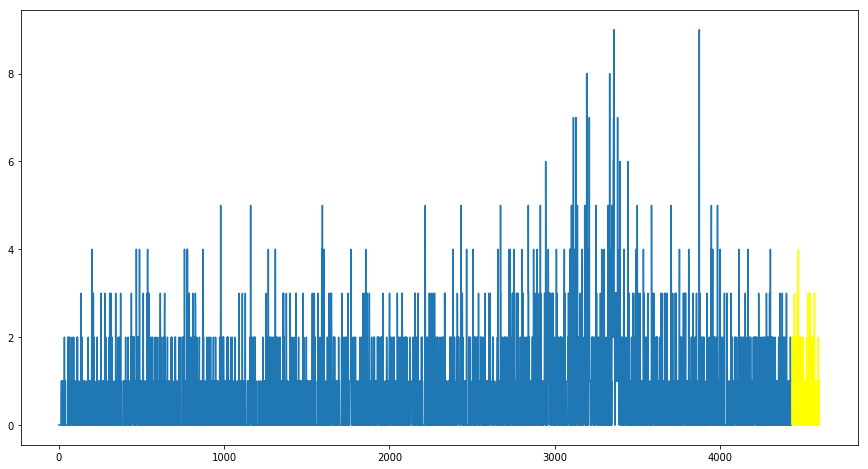

District code:  871e76890ffffff


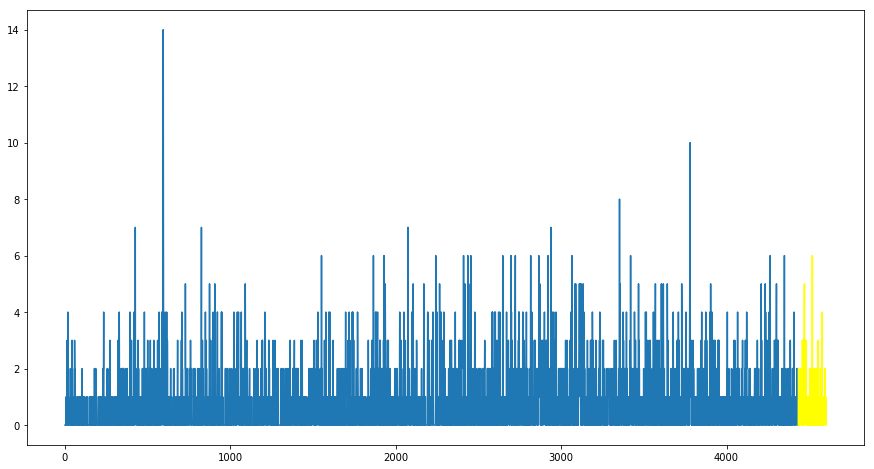

District code:  871e76c69ffffff


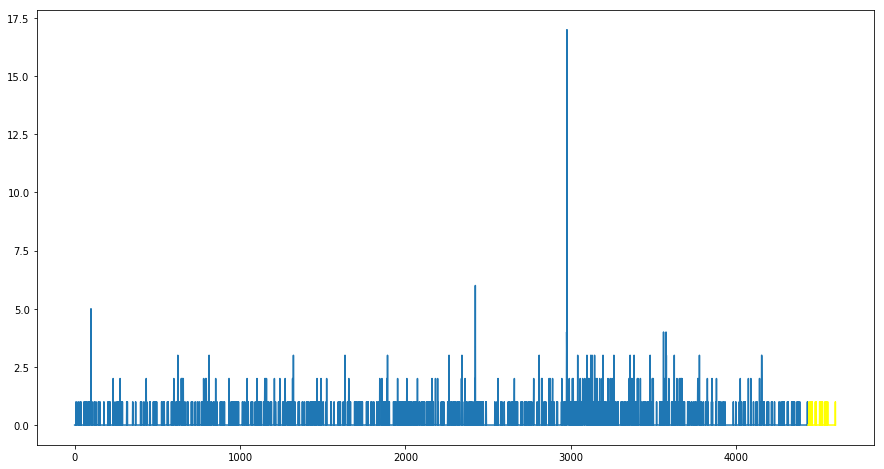

District code:  871e768aaffffff


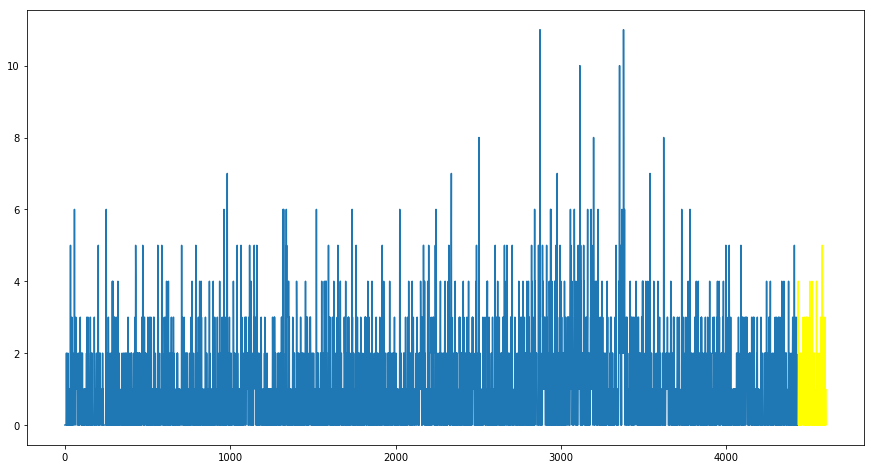

District code:  871e76888ffffff

Model is not applicable
District code:  871e76886ffffff


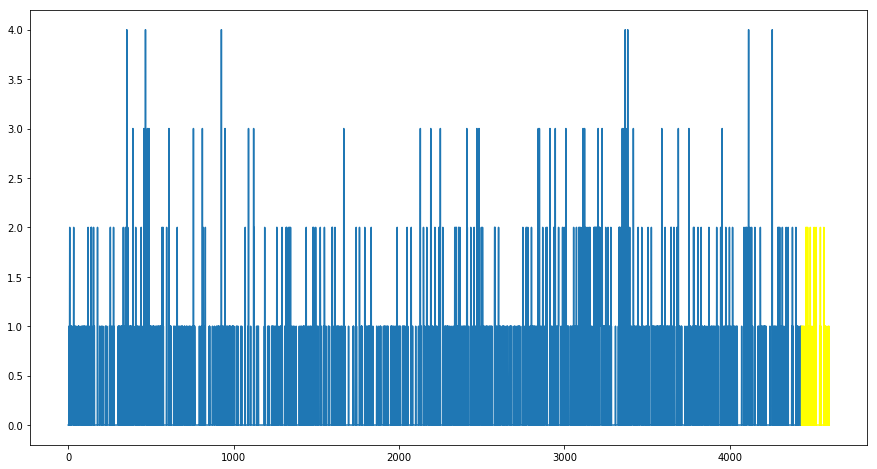

District code:  871e7688cffffff


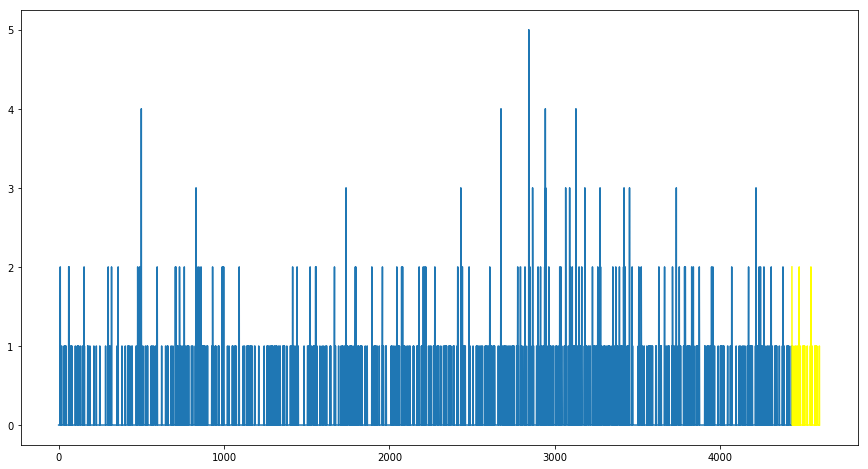

District code:  871e768b5ffffff
Skipped, lack of data
District code:  871e76124ffffff


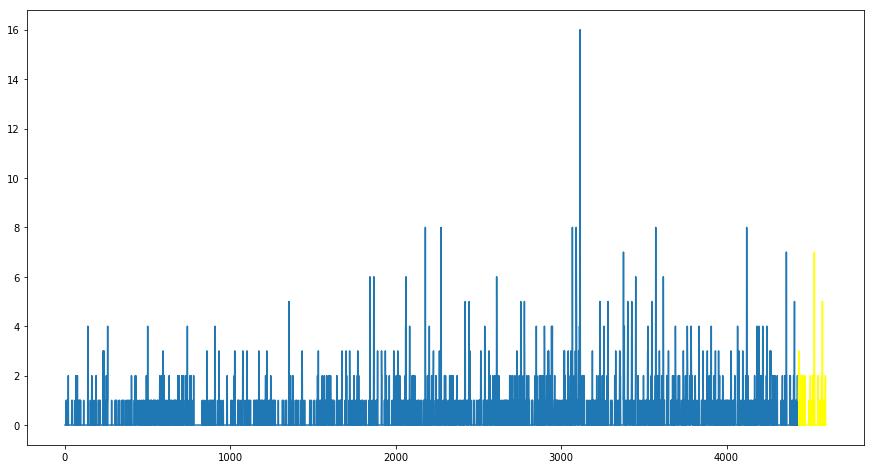

District code:  871e768abffffff


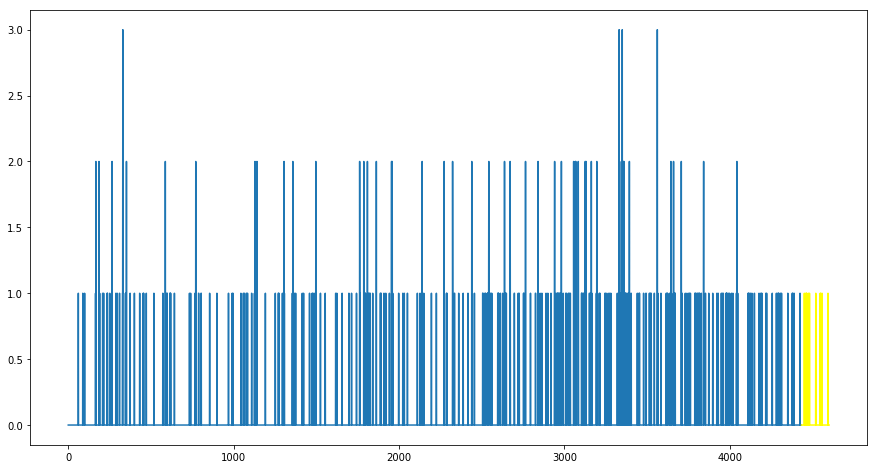

District code:  871e76c68ffffff


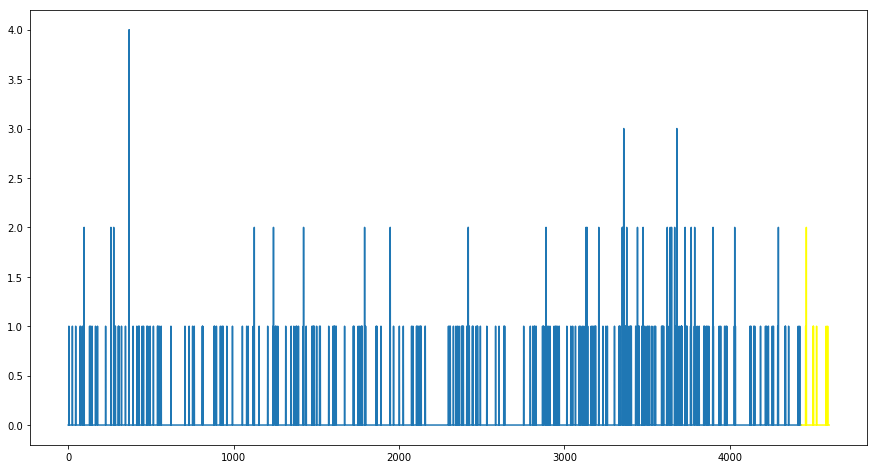

District code:  871e76c6cffffff
Skipped, lack of data
District code:  871e76122ffffff


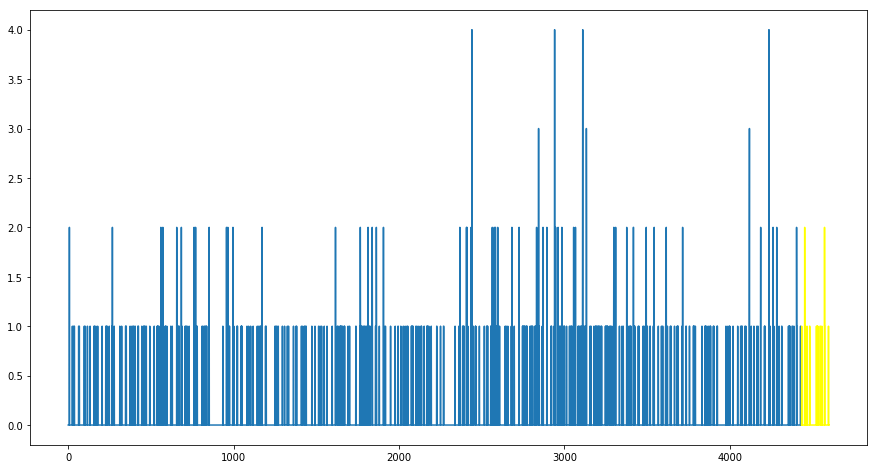

District code:  871e76130ffffff
Skipped, lack of data
District code:  871e768a8ffffff
Skipped, lack of data
District code:  871e76136ffffff
Skipped, lack of data
District code:  871e76884ffffff
Skipped, lack of data
District code:  871e768aeffffff
Skipped, lack of data
District code:  871e76c6bffffff
Skipped, lack of data
District code:  871e76120ffffff
Skipped, lack of data
District code:  871e7688bffffff
Skipped, lack of data
District code:  871e76894ffffff
Skipped, lack of data
District code:  871e768a3ffffff
Skipped, lack of data
CPU times: user 2min 39s, sys: 3.1 s, total: 2min 42s
Wall time: 2min 40s


In [56]:
%%time
type_='forward'
forecast_future = start(type_)

District code:  871e7689cffffff


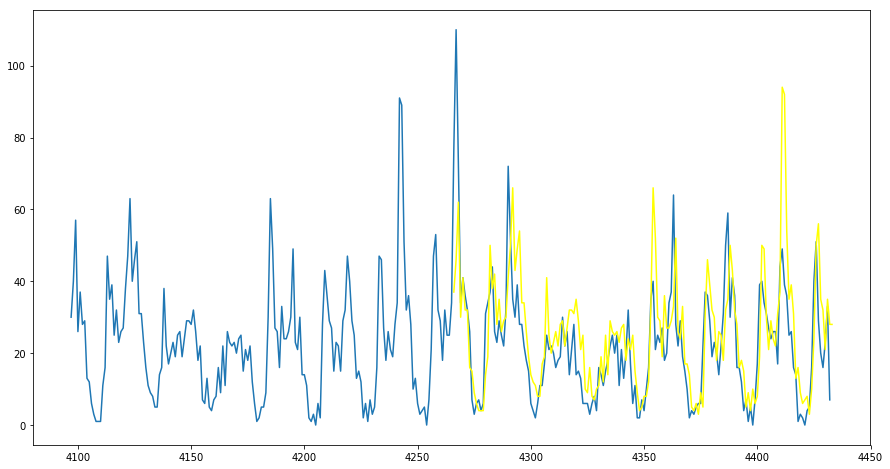

Mean absolute error:  7.666666666666667
Mean squared error:  125.94047619047619
R2 score:  0.5264060815394856
District code:  871e76883ffffff


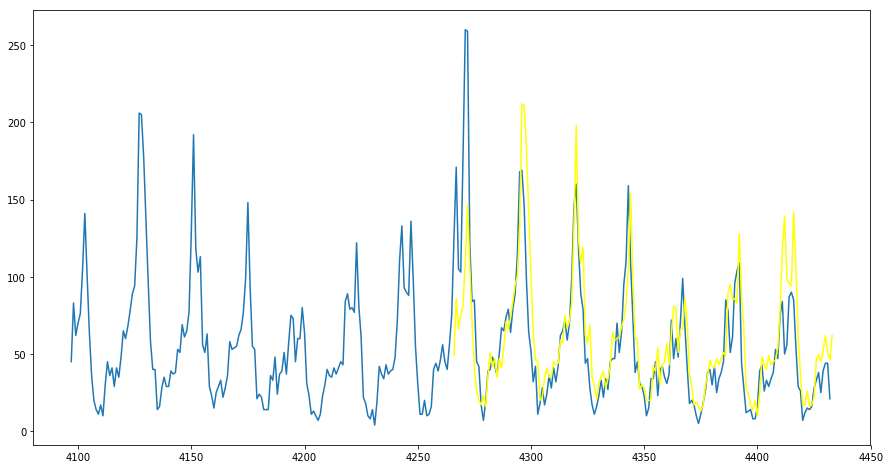

Mean absolute error:  17.136904761904763
Mean squared error:  682.625
R2 score:  0.6351108572088302
District code:  871e76882ffffff


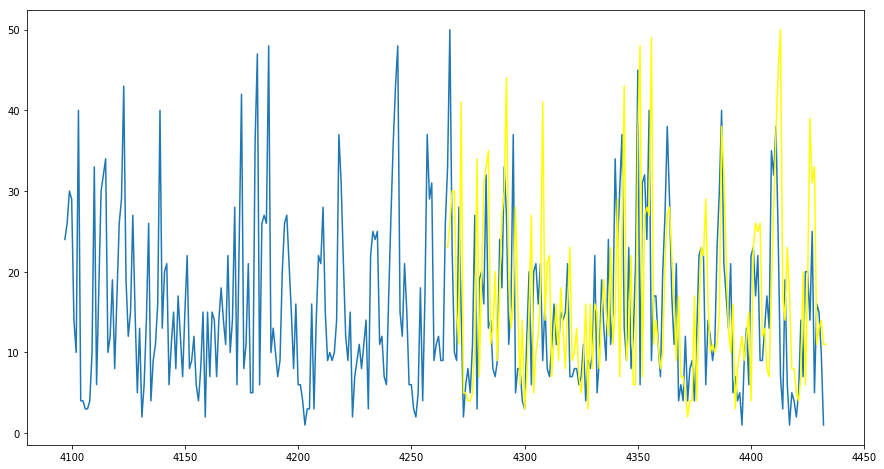

Mean absolute error:  4.928571428571429
Mean squared error:  45.19047619047619
R2 score:  0.538701911948521
District code:  871e7689dffffff


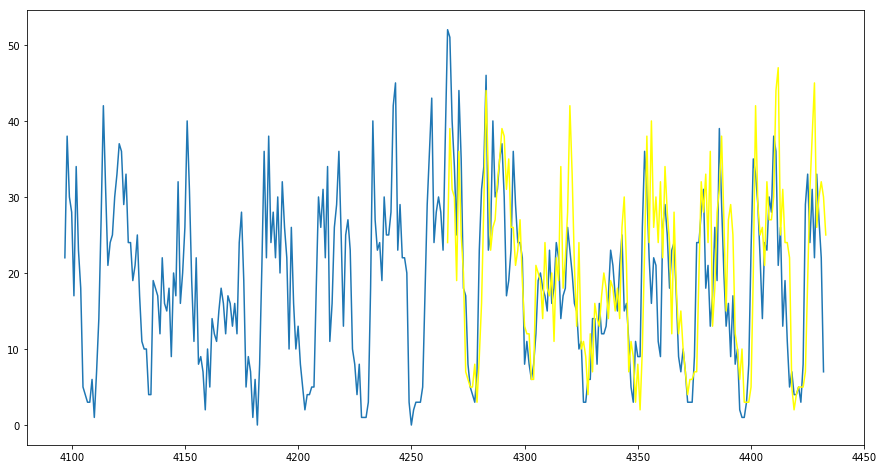

Mean absolute error:  5.660714285714286
Mean squared error:  56.041666666666664
R2 score:  0.5237491610690261
District code:  871e768b1ffffff


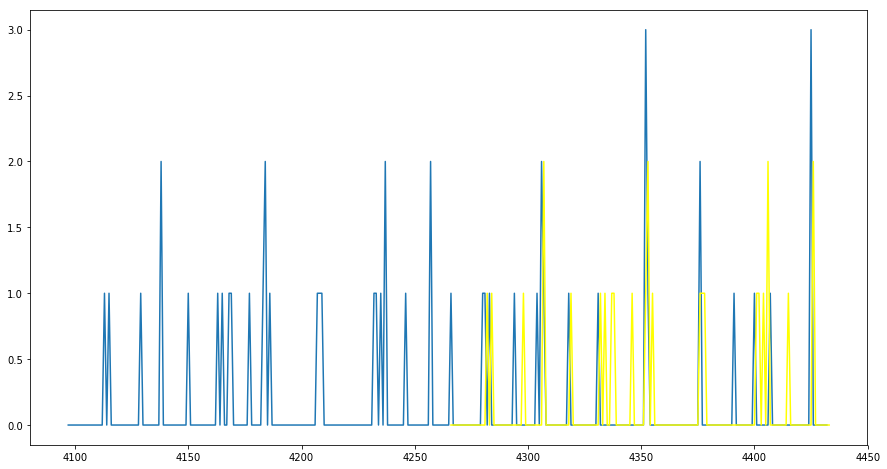

Mean absolute error:  0.1488095238095238
Mean squared error:  0.16071428571428573
R2 score:  0.24688693342188273
District code:  871e76135ffffff


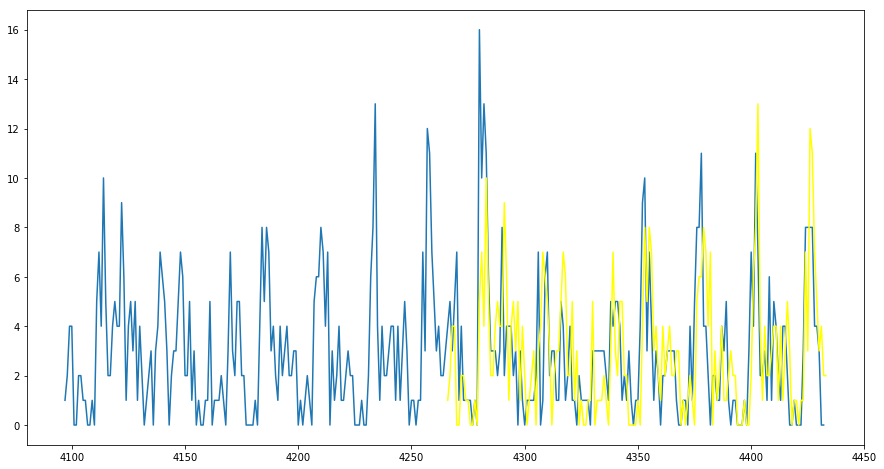

Mean absolute error:  1.7261904761904763
Mean squared error:  5.5476190476190474
R2 score:  0.3156643356643357
District code:  871e76899ffffff


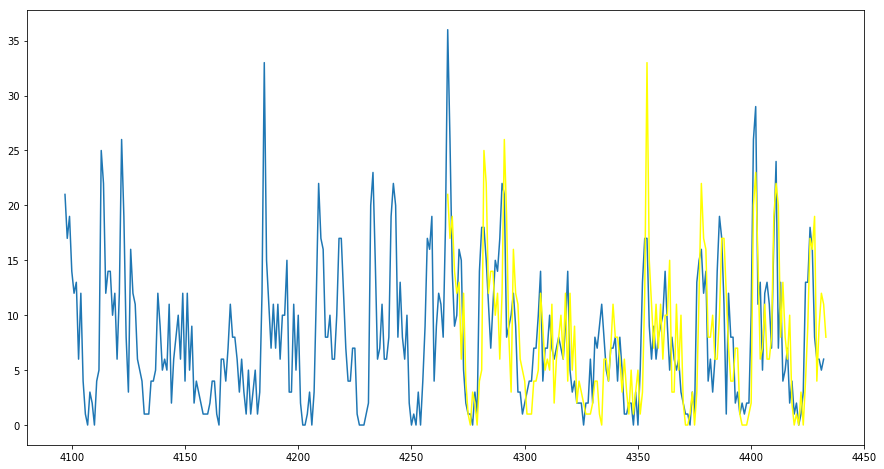

Mean absolute error:  3.1726190476190474
Mean squared error:  18.601190476190474
R2 score:  0.5318147484596706
District code:  871e76895ffffff


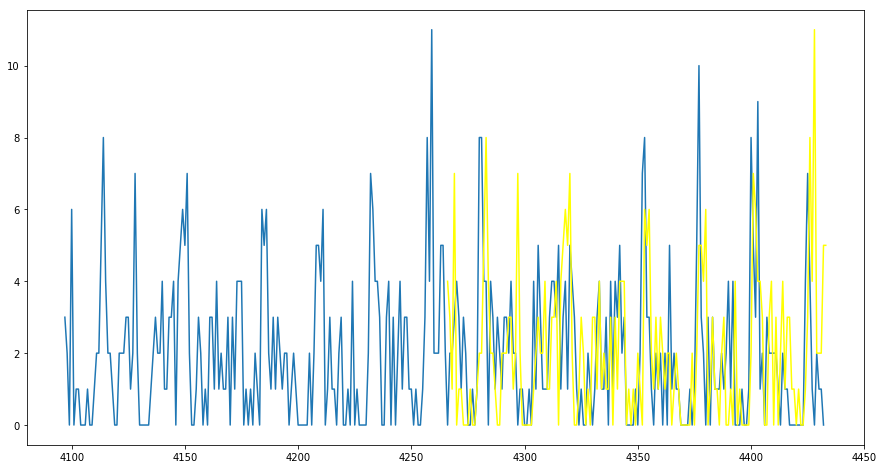

Mean absolute error:  1.5773809523809523
Mean squared error:  4.875
R2 score:  -0.19774365402695082
District code:  871e76898ffffff


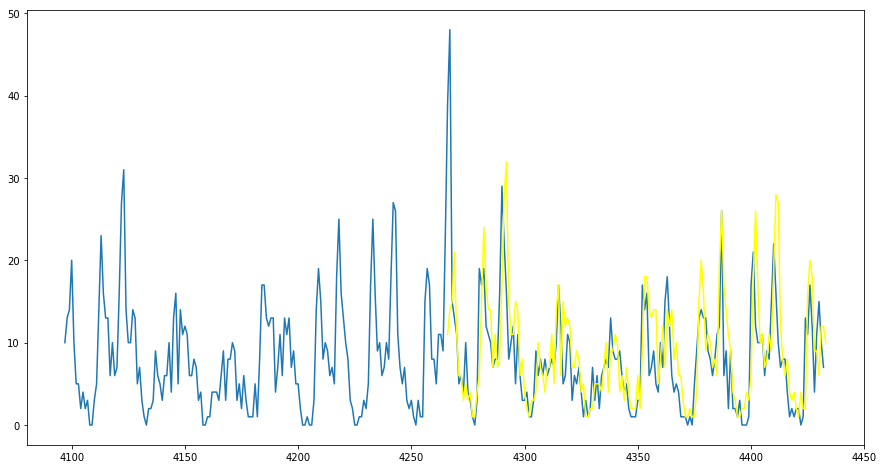

Mean absolute error:  3.2976190476190474
Mean squared error:  25.821428571428573
R2 score:  0.45371095667895744
District code:  871e76126ffffff


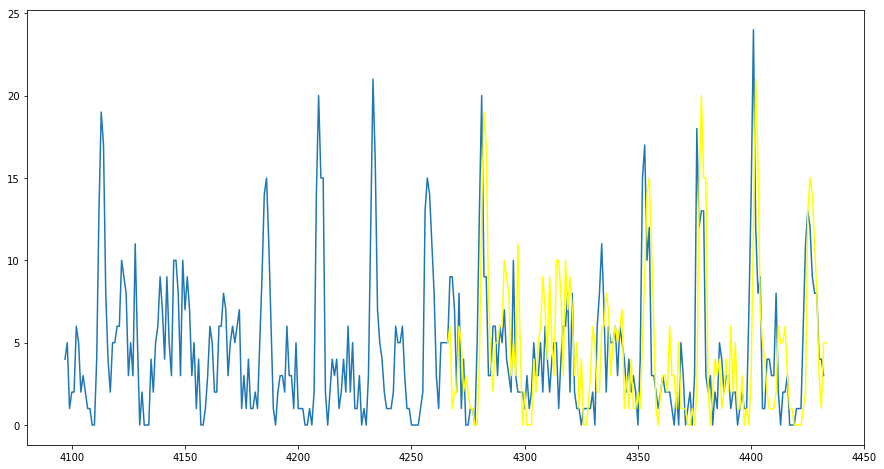

Mean absolute error:  2.267857142857143
Mean squared error:  8.589285714285714
R2 score:  0.5137116138000759
District code:  871e76880ffffff


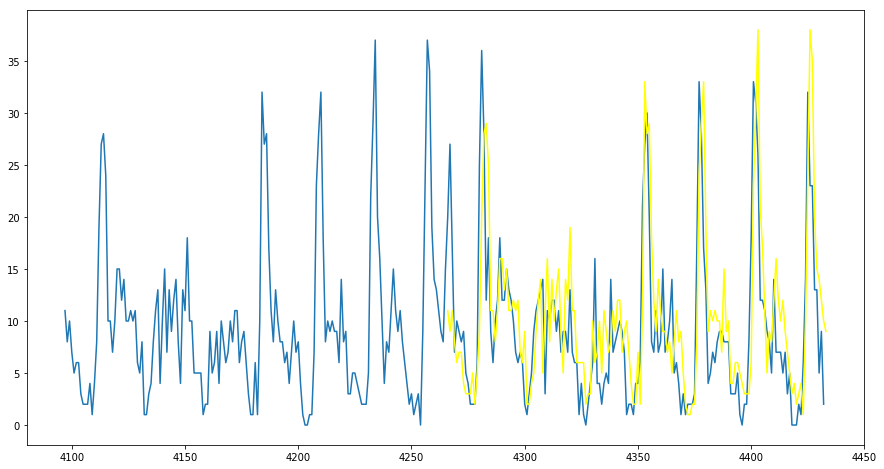

Mean absolute error:  3.4107142857142856
Mean squared error:  20.386904761904763
R2 score:  0.6417542461523136
District code:  871e76881ffffff


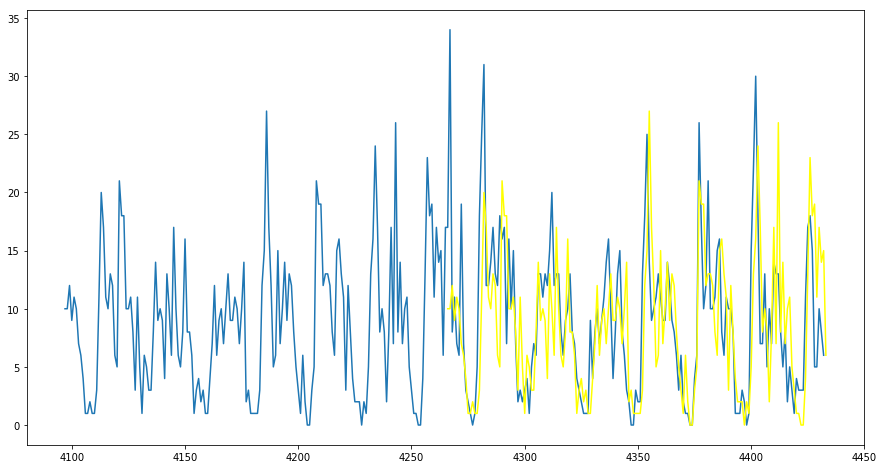

Mean absolute error:  3.5416666666666665
Mean squared error:  23.875
R2 score:  0.4394908697087939
District code:  871e76885ffffff


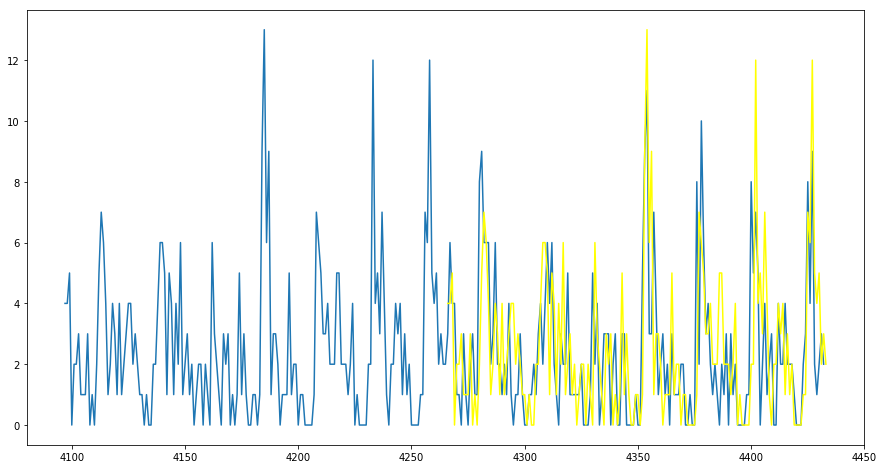

Mean absolute error:  1.5833333333333333
Mean squared error:  5.023809523809524
R2 score:  0.05801068268183185
District code:  871e7689affffff


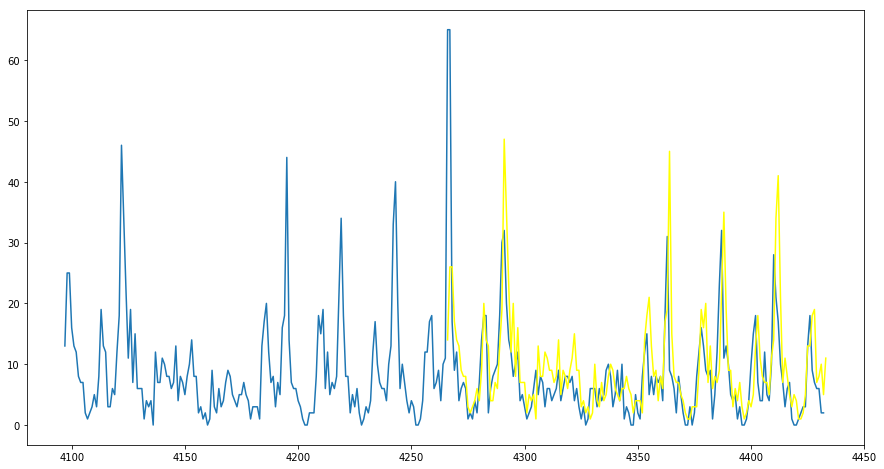

Mean absolute error:  3.6785714285714284
Mean squared error:  37.773809523809526
R2 score:  0.5208997016543153
District code:  871e7688affffff


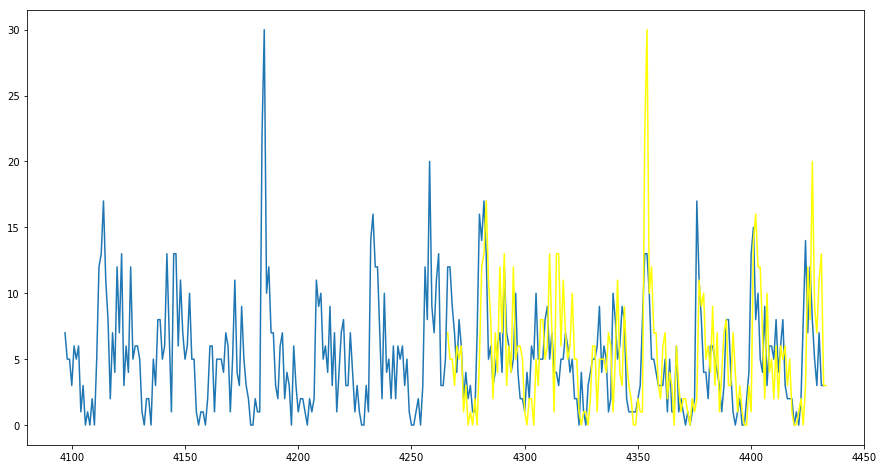

Mean absolute error:  2.625
Mean squared error:  13.56547619047619
R2 score:  0.019481201293795603
District code:  871e76134ffffff


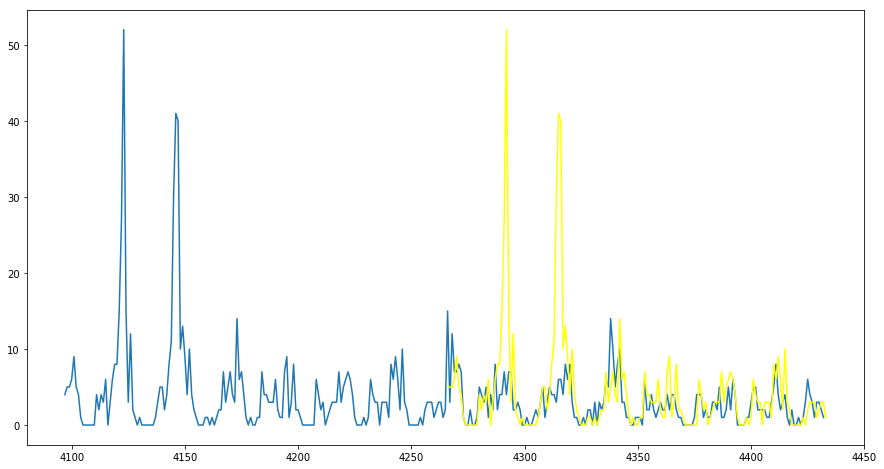

Mean absolute error:  2.7797619047619047
Mean squared error:  42.708333333333336
R2 score:  -4.803255484784147
District code:  871e76c6dffffff


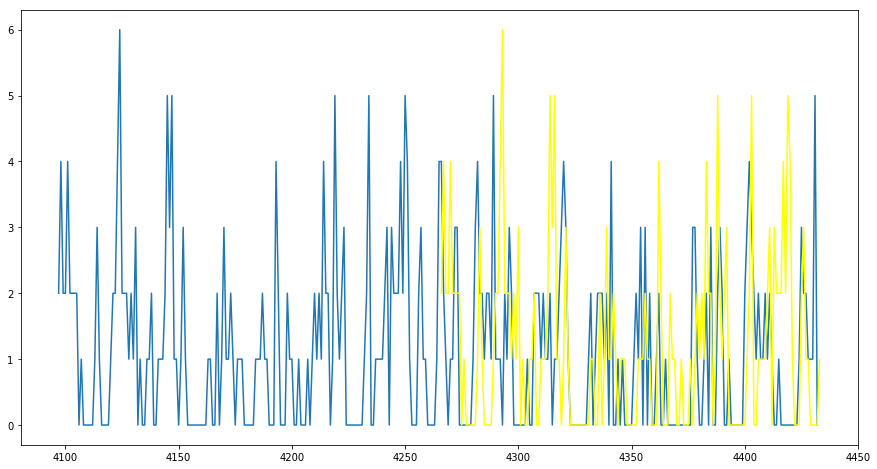

Mean absolute error:  1.0833333333333333
Mean squared error:  2.630952380952381
R2 score:  -0.7599544937428897
District code:  871e76891ffffff


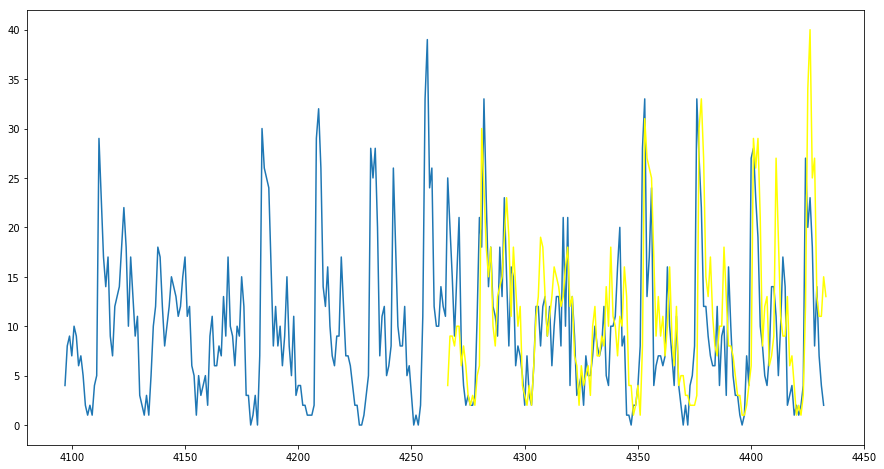

Mean absolute error:  4.107142857142857
Mean squared error:  30.25
R2 score:  0.44786554391428934
District code:  871e7689effffff


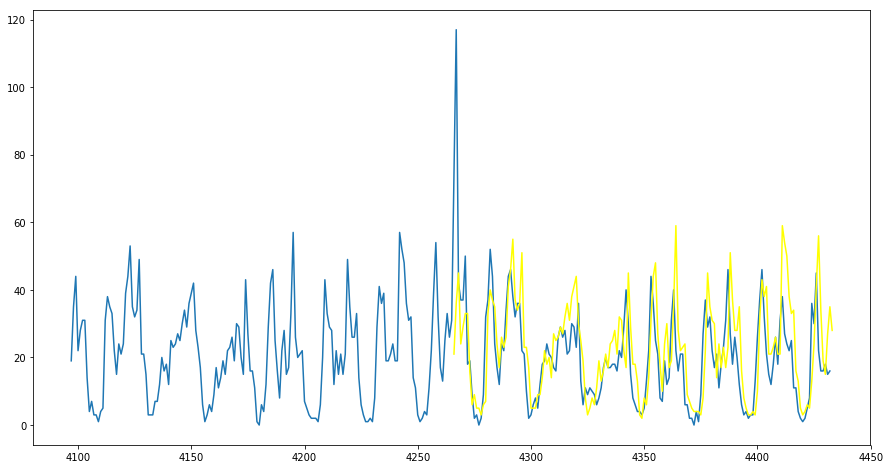

Mean absolute error:  6.571428571428571
Mean squared error:  100.47619047619048
R2 score:  0.5526930078470843
District code:  871e76893ffffff


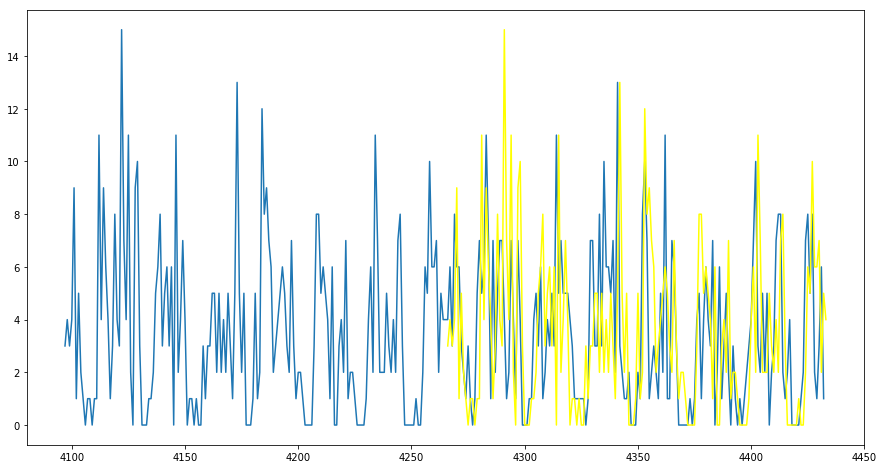

Mean absolute error:  2.017857142857143
Mean squared error:  7.446428571428571
R2 score:  0.09603606083545524
District code:  871e7689bffffff


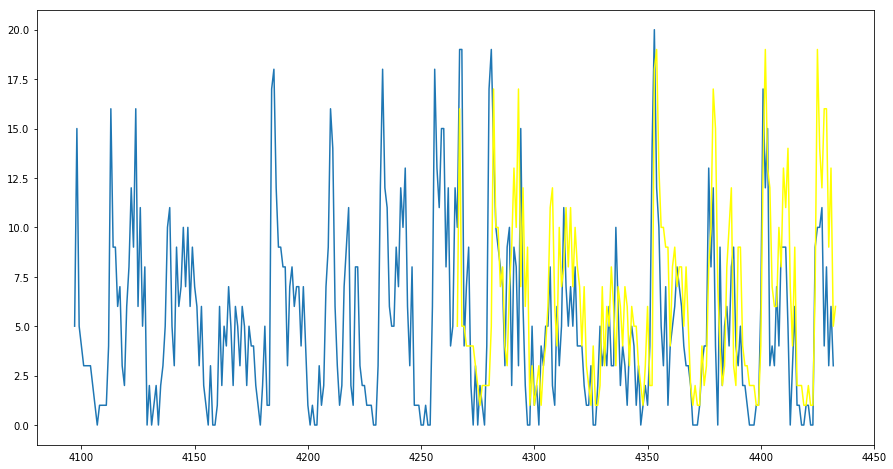

Mean absolute error:  2.8452380952380953
Mean squared error:  15.571428571428571
R2 score:  0.20432770644593634
District code:  871e7688effffff


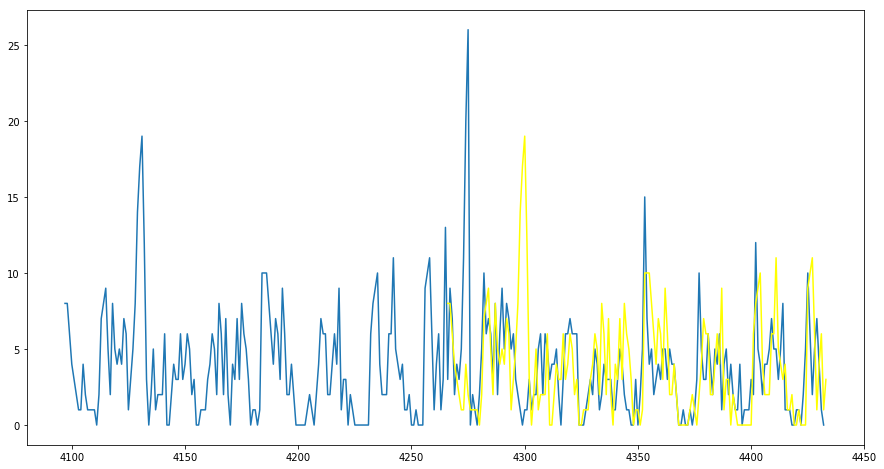

Mean absolute error:  2.6666666666666665
Mean squared error:  18.285714285714285
R2 score:  -0.4898544198009853
District code:  871e768b3ffffff


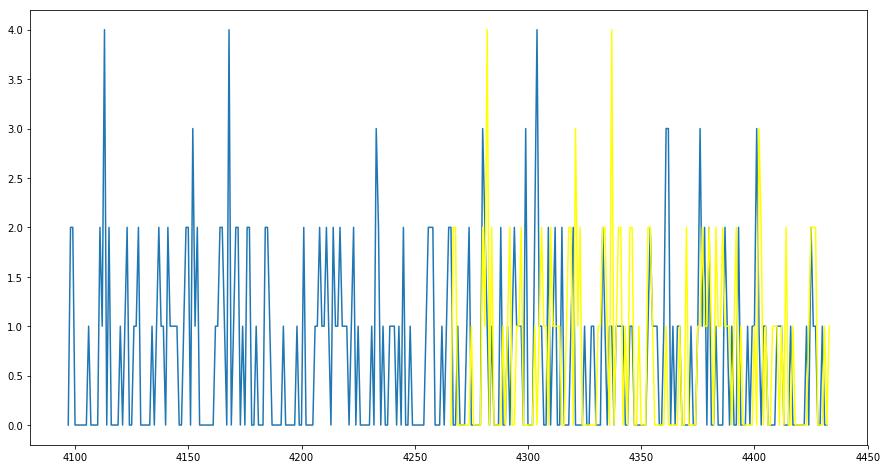

Mean absolute error:  0.7142857142857143
Mean squared error:  1.1428571428571428
R2 score:  -0.5781594011448699
District code:  871e76890ffffff


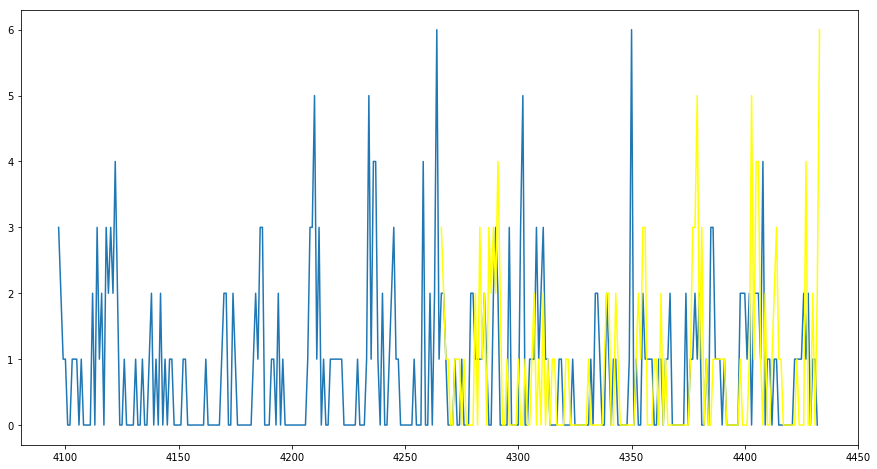

Mean absolute error:  0.8809523809523809
Mean squared error:  1.880952380952381
R2 score:  -0.7819548872180451
District code:  871e76c69ffffff


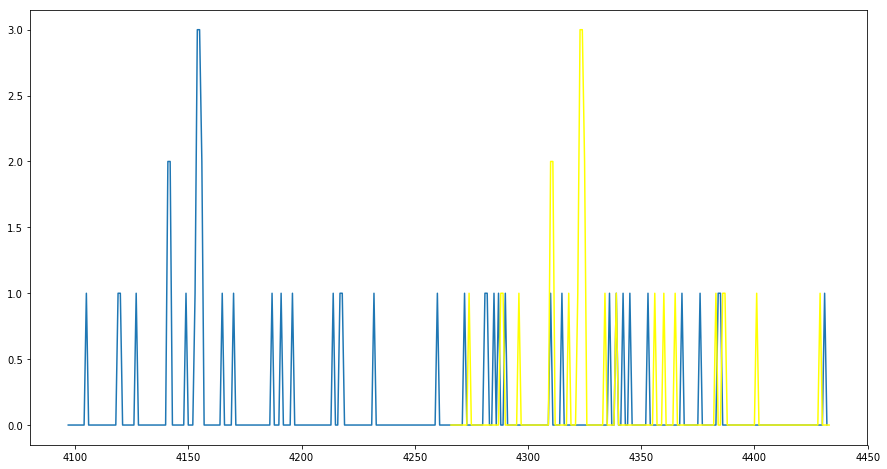

Mean absolute error:  0.23809523809523808
Mean squared error:  0.3333333333333333
R2 score:  -2.4844444444444433
District code:  871e768aaffffff


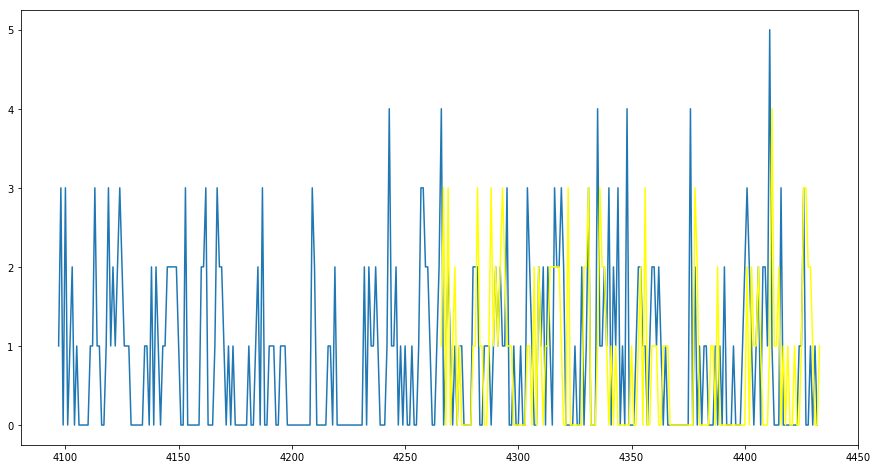

Mean absolute error:  0.8214285714285714
Mean squared error:  1.4642857142857142
R2 score:  -0.2424615939632624
District code:  871e76888ffffff


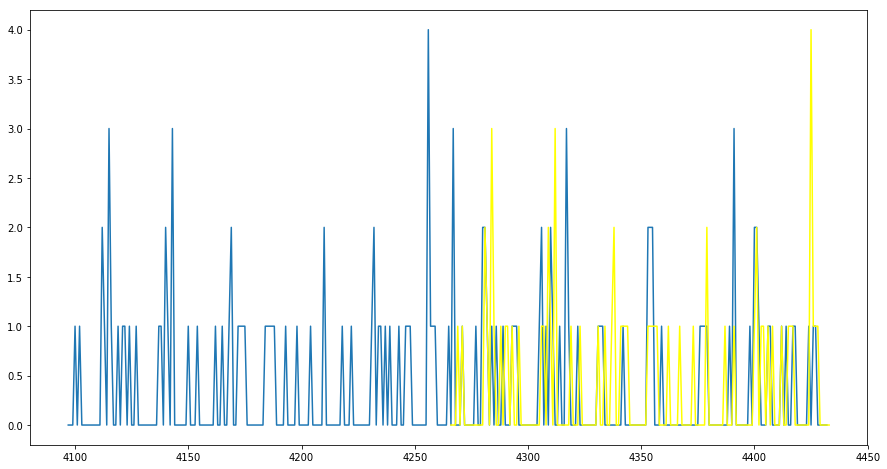

Mean absolute error:  0.44642857142857145
Mean squared error:  0.6726190476190477
R2 score:  -0.4943324937027711
District code:  871e76886ffffff


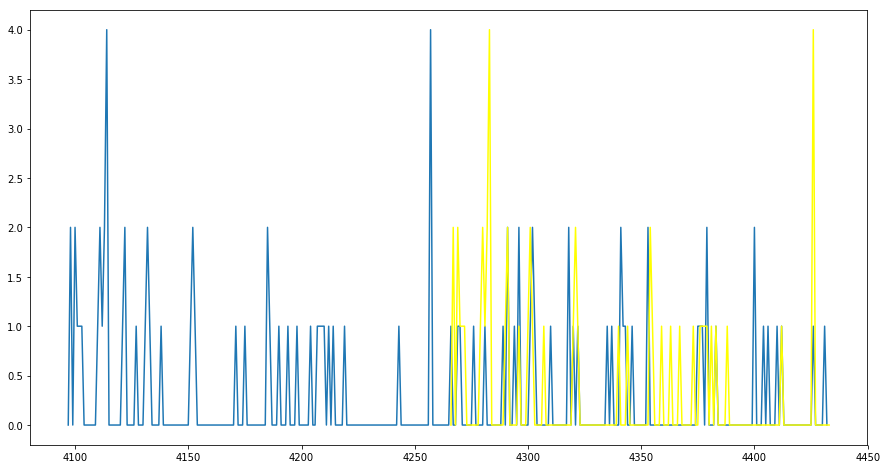

Mean absolute error:  0.40476190476190477
Mean squared error:  0.6785714285714286
R2 score:  -1.3752945553764109
District code:  871e7688cffffff


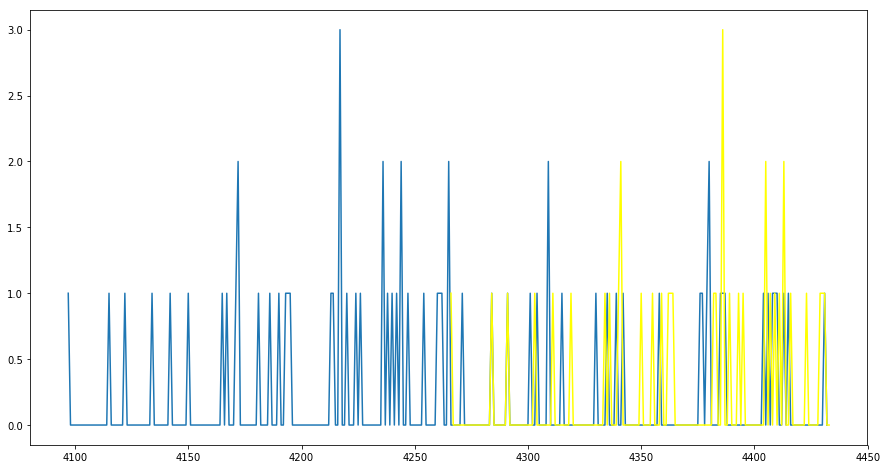

Mean absolute error:  0.2857142857142857
Mean squared error:  0.34523809523809523
R2 score:  -0.8542340627973357
District code:  871e768b5ffffff
Skipped, lack of data
District code:  871e76124ffffff


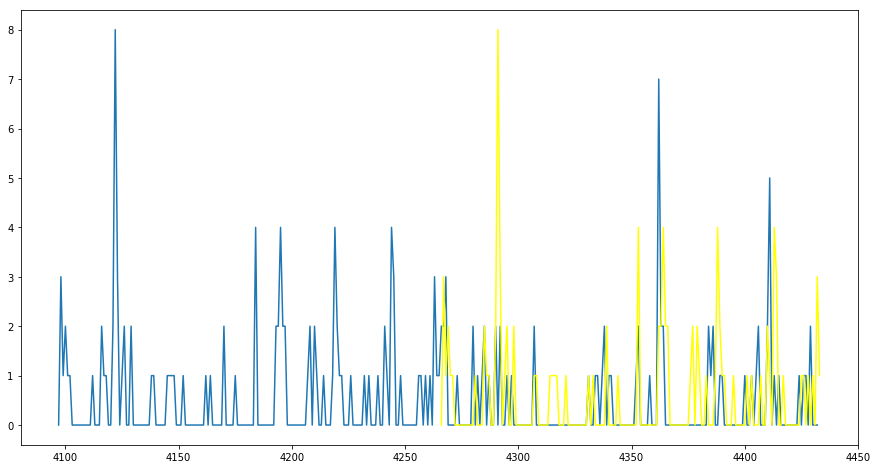

Mean absolute error:  0.6488095238095238
Mean squared error:  1.4702380952380953
R2 score:  -0.7483041921213396
District code:  871e768abffffff


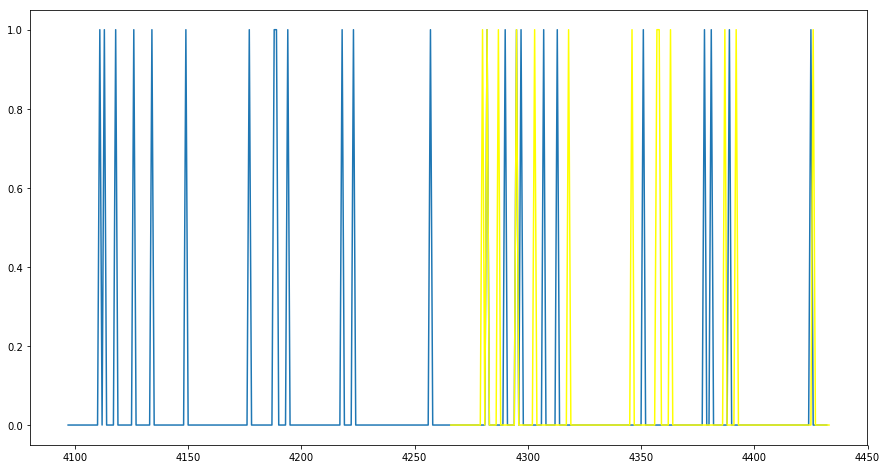

Mean absolute error:  0.13095238095238096
Mean squared error:  0.13095238095238096
R2 score:  -1.1401273885350318
District code:  871e76c68ffffff


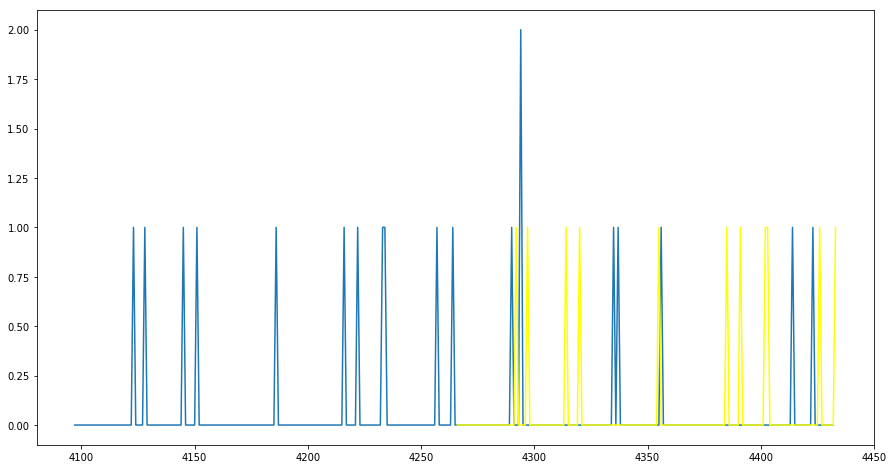

Mean absolute error:  0.1130952380952381
Mean squared error:  0.125
R2 score:  -1.1831683168316833
District code:  871e76c6cffffff
Skipped, lack of data
District code:  871e76122ffffff


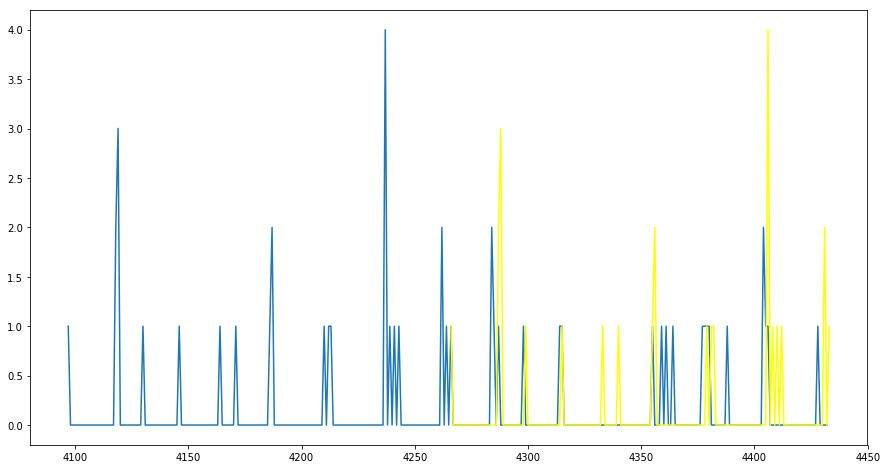

Mean absolute error:  0.20238095238095238
Mean squared error:  0.2976190476190476
R2 score:  -1.1627188465499483
District code:  871e76130ffffff
Skipped, lack of data
District code:  871e768a8ffffff
Skipped, lack of data
District code:  871e76136ffffff
Skipped, lack of data
District code:  871e76884ffffff
Skipped, lack of data
District code:  871e768aeffffff
Skipped, lack of data
District code:  871e76c6bffffff
Skipped, lack of data
District code:  871e76120ffffff
Skipped, lack of data
District code:  871e7688bffffff
Skipped, lack of data
District code:  871e76894ffffff
Skipped, lack of data
District code:  871e768a3ffffff
Skipped, lack of data
CPU times: user 2min 39s, sys: 3.73 s, total: 2min 42s
Wall time: 2min 42s


In [59]:
%%time
type_='backward'
forecast_future, district_metrics = start(type_)